In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
df = pq.read_table("yellow_tripdata_2025-05.parquet")
df = df.to_pandas()

In [3]:
df = df.dropna()

In [4]:
print("Summary Stats:\n", df.describe())

Summary Stats:
            VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  3.395669e+06                     3395669                     3395669   
mean   1.879403e+00  2025-05-16 05:36:37.598041  2025-05-16 05:54:11.040459   
min    1.000000e+00         2009-01-01 00:20:39         2009-01-01 00:20:49   
25%    2.000000e+00         2025-05-08 15:42:29         2025-05-08 16:04:38   
50%    2.000000e+00         2025-05-15 21:17:34         2025-05-15 21:33:30   
75%    2.000000e+00         2025-05-23 13:06:24         2025-05-23 13:25:26   
max    7.000000e+00         2025-06-01 00:04:31         2025-06-04 11:17:10   
std    8.154452e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     3.395669e+06   3.395669e+06  3.395669e+06  3.395669e+06   
mean      1.295270e+00   4.030918e+00  2.432585e+00  1.652935e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00

In [6]:
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance'].replace(0, np.nan)
df['total_per_mile'] = df['total_amount'] / df['trip_distance'].replace(0, np.nan)
df['speed_mph'] = df['trip_distance'] / (df['trip_duration'].replace(0, np.nan) / 60)

In [30]:
df = df[(df['fare_amount'] > 0) & (df['total_amount'] > 0)
    & (df['trip_distance'] > 0.1) 
    & (df["speed_mph"] > 1) & (df["speed_mph"] < 100)
    & (df["fare_per_mile"] < 100)]

In [7]:
features = ['trip_distance', 'trip_duration', 'passenger_count', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'fare_per_mile', 'total_per_mile', 'speed_mph']

In [33]:
valid_idx = df[features].dropna().index
X = df.loc[valid_idx, features]
X_scaled = StandardScaler().fit_transform(X)

In [58]:
iso = IsolationForest(contamination=0.001, random_state=42)
anomalies = iso.fit_predict(X_scaled)

In [59]:
df["anomaly"] = np.nan
df.loc[valid_idx, "anomaly"] = anomalies
df["anomaly_score"] = iso.decision_function(X_scaled)

In [60]:
anomalies = df[df['anomaly'] == -1]
normals = df[df['anomaly'] == 1]

In [61]:
anomalies[features].describe()

,trip_distance,trip_duration,passenger_count,fare_amount,tip_amount,tolls_amount,total_amount,fare_per_mile,total_per_mile,speed_mph
count,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000
mean,33.512192,72.233359,2.120700,182.419199,22.359584,21.174700,229.655797,7.916499,10.232991,31.125022
std,20.637126,54.194318,1.246002,98.684468,20.533193,10.645442,102.770631,11.020768,14.064824,11.664898
min,0.730000,0.933333,0.000000,53.000000,0.000000,0.000000,79.130000,0.452981,0.488947,1.383391
25%,20.310000,43.650000,1.000000,120.000000,0.000000,14.570000,161.065000,4.629403,5.995706,22.473096
50%,32.375000,65.841667,2.000000,158.400000,22.935000,21.000000,206.290000,5.375200,7.025871,32.279696
75%,40.417500,92.883333,3.000000,212.000000,36.422500,27.940000,266.140000,6.539810,8.377253,39.671525
max,308.850000,1430.450000,6.000000,1583.600000,149.330000,128.110000,1614.290000,98.747253,139.000000,85.190840


In [62]:
normals[features].describe()

,trip_distance,trip_duration,passenger_count,fare_amount,tip_amount,tolls_amount,total_amount,fare_per_mile,total_per_mile,speed_mph
count,3.193842e+06,3.193842e+06,3.193842e+06,3.193842e+06,3.193842e+06,3.193842e+06,3.193842e+06,3.193842e+06,3.193842e+06,3.193842e+06
mean,3.457007e+00,1.758481e+01,1.291079e+00,1.995550e+01,3.826441e+00,6.018061e-01,2.993832e+01,8.193552e+00,1.393573e+01,1.056472e+01
std,4.491445e+00,1.572993e+01,7.217647e-01,1.788621e+01,4.102853e+00,2.173977e+00,2.272994e+01,3.849933e+00,7.956241e+00,6.135163e+00
min,1.100000e-01,1.333333e-01,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,1.010000e+00,2.638522e-04,7.278984e-02,1.000772e+00
25%,1.030000e+00,7.983333e+00,1.000000e+00,9.300000e+00,1.500000e+00,0.000000e+00,1.685000e+01,5.818966e+00,8.750000e+00,6.683012e+00
50%,1.740000e+00,1.313333e+01,1.000000e+00,1.350000e+01,3.000000e+00,0.000000e+00,2.201000e+01,7.473684e+00,1.231034e+01,9.040359e+00
75%,3.360000e+00,2.158333e+01,1.000000e+00,2.260000e+01,4.720000e+00,0.000000e+00,3.198000e+01,9.555556e+00,1.693548e+01,1.245016e+01
max,1.329900e+02,3.692867e+03,8.000000e+00,6.652000e+02,4.432100e+02,1.069300e+02,6.756300e+02,9.955714e+01,8.587692e+02,9.994609e+01


In [63]:
lowest_anomalies = df.sort_values('anomaly_score').head(10)
print(lowest_anomalies[features])

         trip_distance  trip_duration  passenger_count  fare_amount  \
790573          107.30     132.500000              3.0        300.0   
1208468           3.33       5.716667              1.0        127.5   
2051402         112.40     167.050000              3.0        427.6   
1508133         101.72     130.433333              4.0        400.0   
1120951          63.09      96.333333              4.0        362.0   
620628            1.22       1.800000              2.0         98.0   
45069           107.49     164.933333              3.0        400.0   
2772117          75.79     102.950000              3.0        400.0   
3148157          89.56     115.450000              4.0        300.0   
2284529          51.87      87.200000              4.0        150.0   

         tip_amount  tolls_amount  total_amount  fare_per_mile  \
790573         0.00         27.94        330.69       2.795899   
1208468       30.80         25.50        184.80      38.288288   
2051402        0.00 

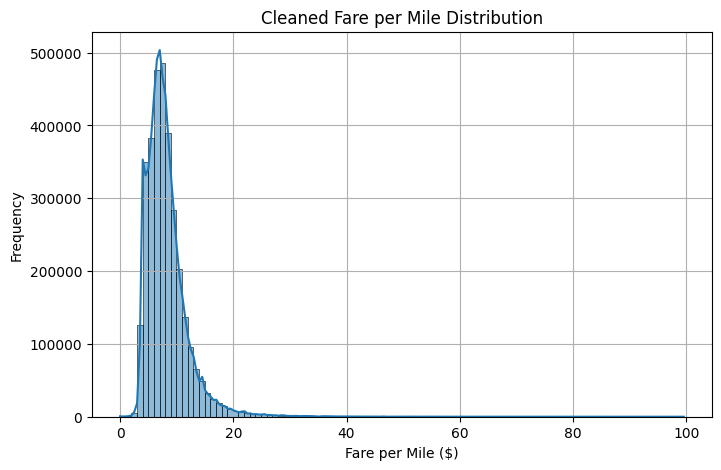

In [27]:
plt.figure(figsize=(8, 5))
sns.histplot(df['fare_per_mile'], bins=100, kde=True)
plt.title('Cleaned Fare per Mile Distribution')
plt.xlabel('Fare per Mile ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

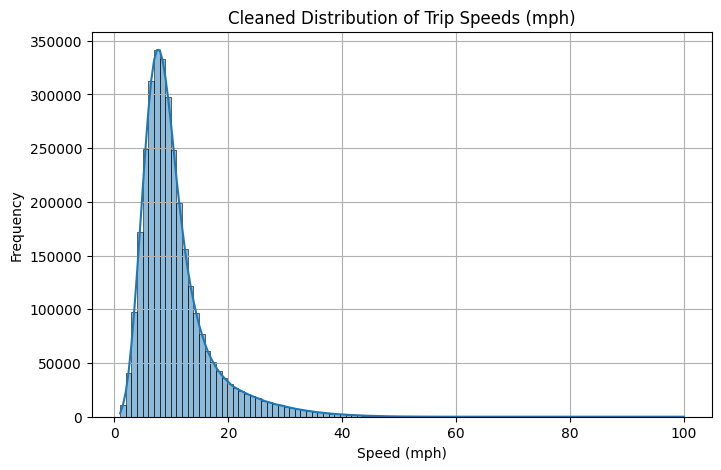

In [31]:
plt.figure(figsize=(8, 5))
sns.histplot(df['speed_mph'], bins=100, kde=True)
plt.title('Cleaned Distribution of Trip Speeds (mph)')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Speed vs. Fare per Mile')

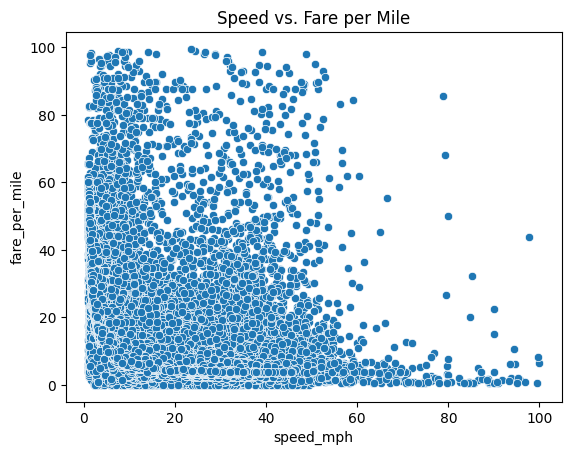

In [39]:
sns.scatterplot(x='speed_mph', y='fare_per_mile', data=df)
plt.title("Speed vs. Fare per Mile")

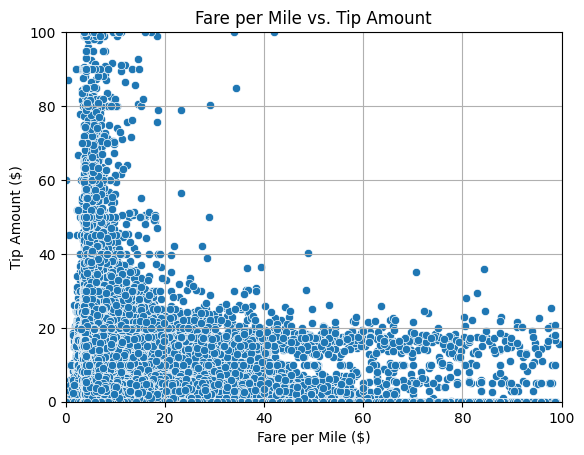

In [40]:
sns.scatterplot(x='fare_per_mile', y='tip_amount', data=df)
plt.title("Fare per Mile vs. Tip Amount")
plt.xlabel("Fare per Mile ($)")
plt.ylabel("Tip Amount ($)")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
plt.show()

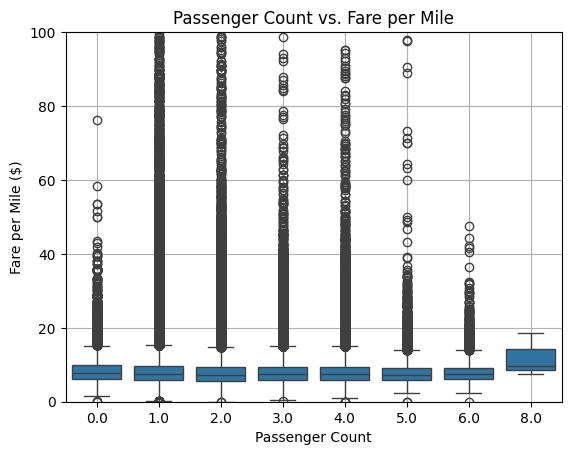

In [41]:
sns.boxplot(x='passenger_count', y='fare_per_mile', data=df)
plt.title("Passenger Count vs. Fare per Mile")
plt.xlabel("Passenger Count")
plt.ylabel("Fare per Mile ($)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

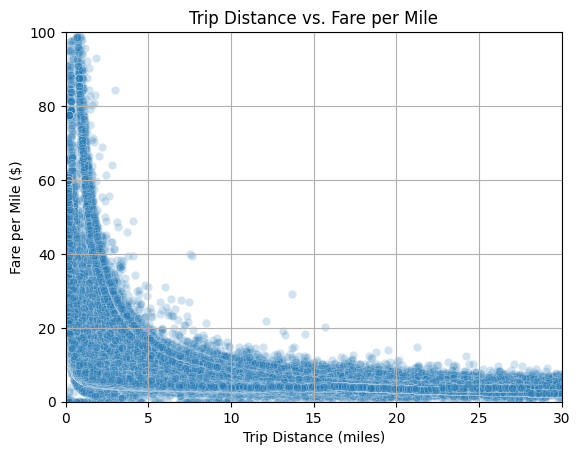

In [42]:
sns.scatterplot(data=df, x='trip_distance', y='fare_per_mile', alpha=0.2)
plt.title('Trip Distance vs. Fare per Mile')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare per Mile ($)')
plt.ylim(0, 100)
plt.xlim(0, 30)  # optionally limit to see detail in the common range
plt.grid(True)
plt.show()

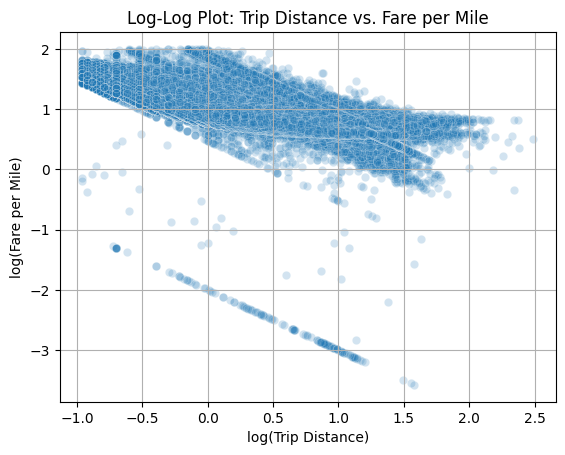

In [43]:
df_log = df[(df['fare_per_mile'] > 0) & (df['trip_distance'] > 0)].copy()
df_log['log_fare_per_mile'] = np.log10(df_log['fare_per_mile'])
df_log['log_trip_distance'] = np.log10(df_log['trip_distance'])

sns.scatterplot(data=df_log, x='log_trip_distance', y='log_fare_per_mile', alpha=0.2)
plt.title('Log-Log Plot: Trip Distance vs. Fare per Mile')
plt.xlabel('log(Trip Distance)')
plt.ylabel('log(Fare per Mile)')
plt.grid(True)
plt.show()

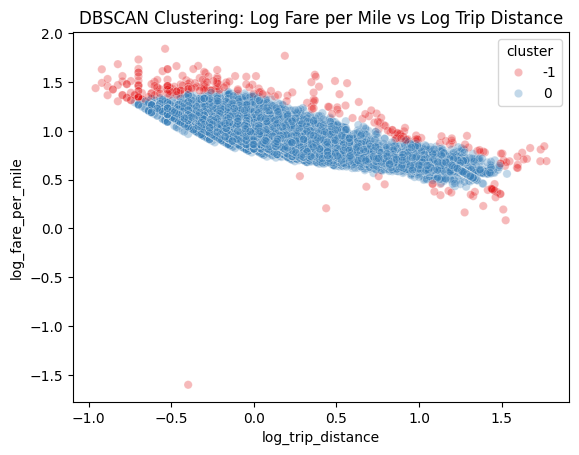

In [47]:
df_sample = df_log.sample(n=20000, random_state=42)
X1 = df_sample[['log_trip_distance', 'log_fare_per_mile']].values
X1_scaled = StandardScaler().fit_transform(X1)

db = DBSCAN(eps=0.3, min_samples=50).fit(X1_scaled)
df_sample['cluster'] = db.labels_

sns.scatterplot(data=df_sample, x='log_trip_distance', y='log_fare_per_mile', hue='cluster', alpha=0.3, palette='Set1')
plt.title('DBSCAN Clustering: Log Fare per Mile vs Log Trip Distance')
plt.show()